Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [260]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [219]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [220]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [221]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [223]:
## creating Train dataset here

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',                      
    label_mode='int',                       
    image_size=(img_height, img_width),     
    batch_size=batch_size,                  
    seed=123,                               
    validation_split=0.2,                   
    subset='training',                      
    shuffle=True                            
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [224]:
## creating validation dataset here

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,                   
    subset='validation',                    
    shuffle=False                           
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [225]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

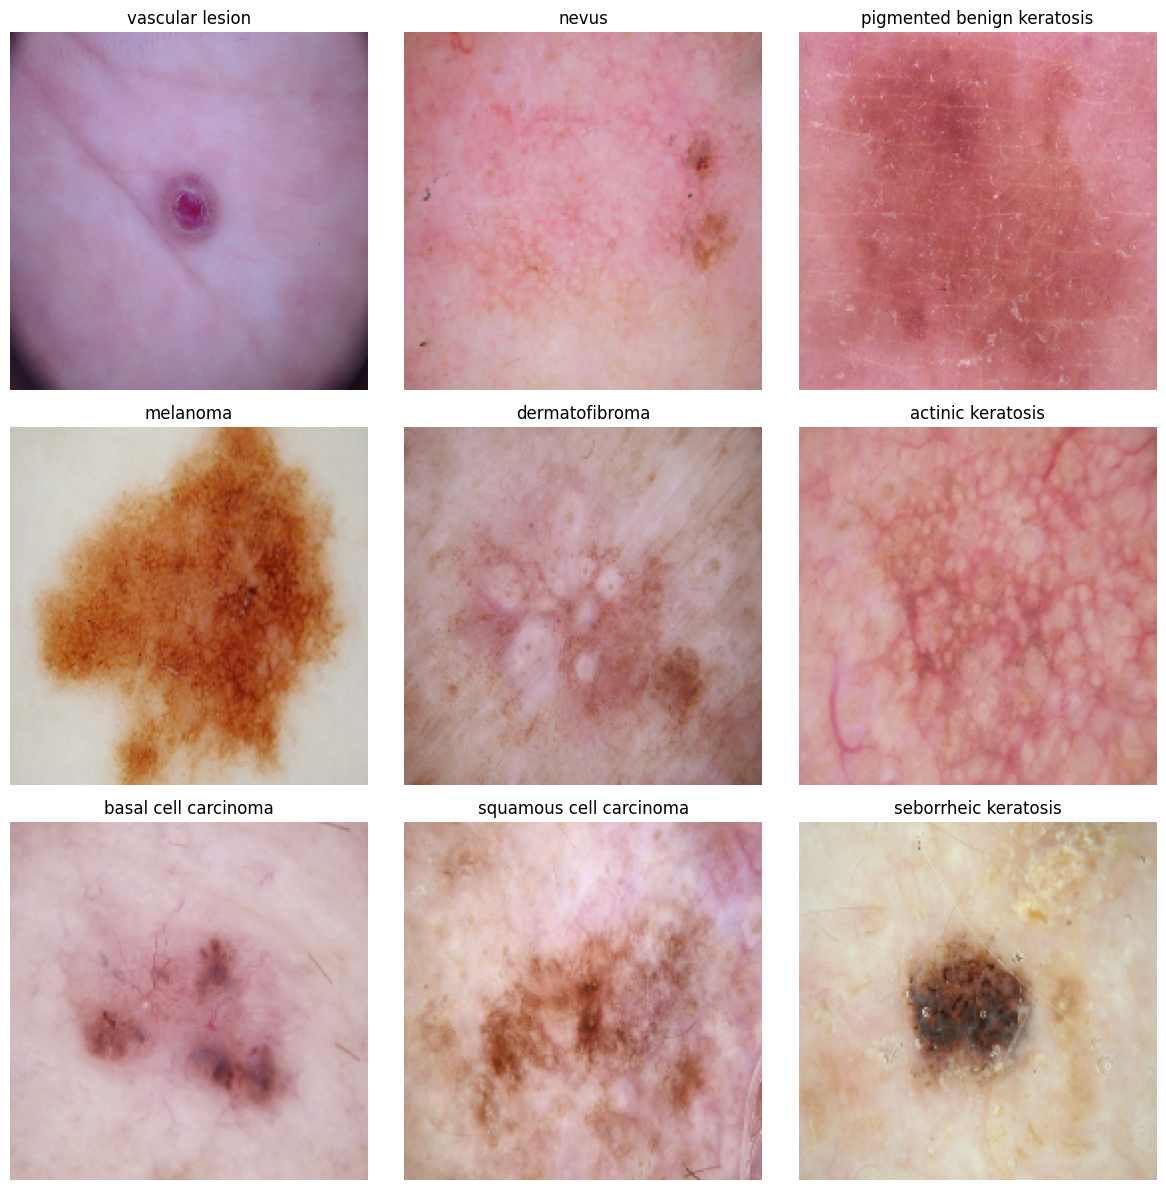

In [226]:

# Create a dictionary to store one instance per class
samples_per_class = {}

# Iterate through the dataset to find one image per class
for image, label in train_ds.unbatch():
    class_name = class_names[label.numpy()]
    if class_name not in samples_per_class:
        samples_per_class[class_name] = image.numpy()
    if len(samples_per_class) == len(class_names):
        break

# Plot the samples
plt.figure(figsize=(12, 12))
for idx, class_name in enumerate(samples_per_class.keys()):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(samples_per_class[class_name].astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [227]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [231]:
model = Sequential()
model.add(layers.Rescaling(1.0 / 255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),

model.add(Conv2D(64, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),

model.add(Conv2D(128, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),
model.add(Dropout(0.5)),

model.add(Conv2D(256, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),

model.add(Flatten()),
model.add(Dense(1024, activation='relu')),
model.add(Dropout(0.25)),
model.add(Dense(9, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [233]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [234]:
# View the summary of all layers
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_55 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1024)                │      21,234,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,634,249 (82.53 MB)

 Trainable params: 21,633,289 (82.52 MB)

 Non-trainable params: 960 (3.75 KB)

### Train the model

In [235]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 421ms/step - accuracy: 0.2513 - loss: 22.9935 - val_accuracy: 0.0089 - val_loss: 3.8929
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 442ms/step - accuracy: 0.3072 - loss: 3.9306 - val_accuracy: 0.0000e+00 - val_loss: 8.5654
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 435ms/step - accuracy: 0.4318 - loss: 1.9512 - val_accuracy: 0.1096 - val_loss: 22.0798
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - accuracy: 0.4707 - loss: 1.6096 - val_accuracy: 0.1119 - val_loss: 19.3720
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - accuracy: 0.4669 - loss: 1.6122 - val_accuracy: 0.0649 - val_loss: 16.6867
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.5587 - loss: 1.2994 - val_accuracy: 0.1141 - val_loss: 22.8135
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 415ms/step - accuracy: 0.5704 - loss: 1.2588 - val_accuracy: 0.1163 - val_loss: 12.9228
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 423ms/step - accuracy: 0.6021 - loss: 1.1445 

### Visualizing training results

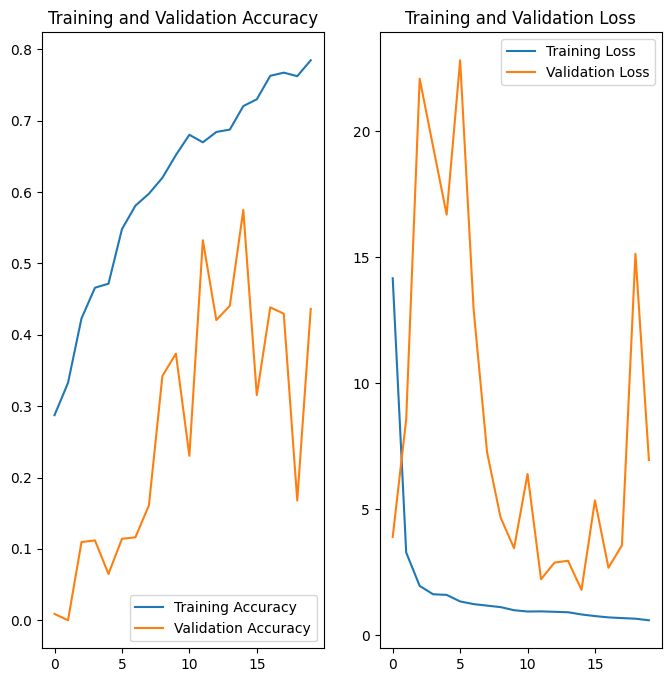

In [236]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- This model is overfitting with training accuracy as 0.81 and validation accuracy as 0.43
- While the training loss is clearly decreasing, but the validation loss is fluctuating a lot.

In [237]:
# Adding an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

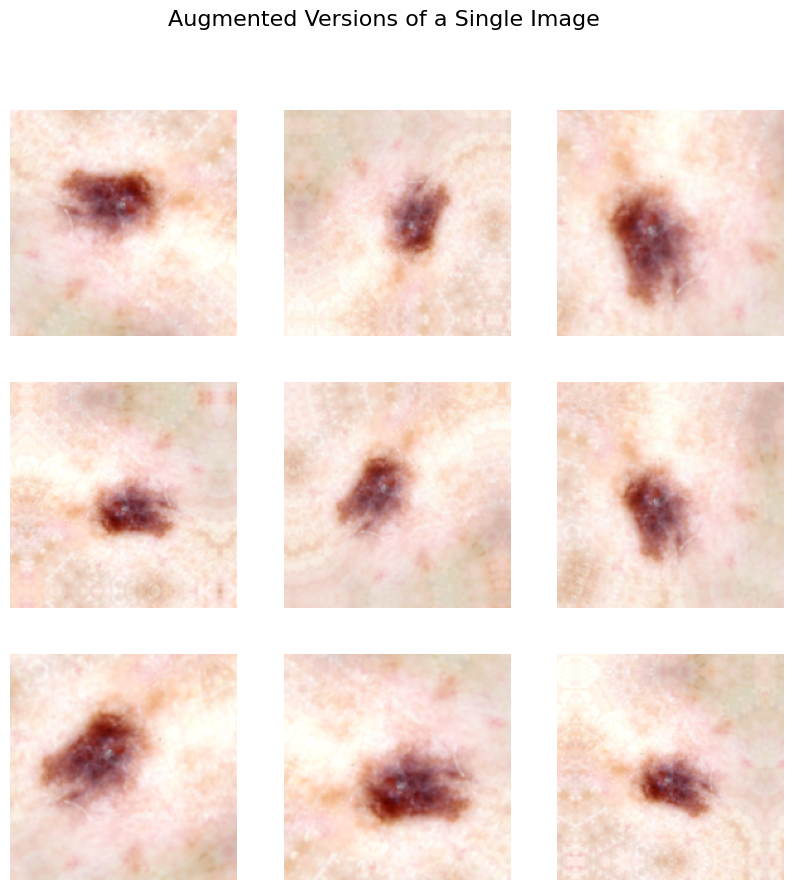

In [239]:
# visualize how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.suptitle("Augmented Versions of a Single Image", fontsize=16)
    plt.show()

### Todo:
### Create the model, compile and train the model


In [241]:
model = Sequential()
model.add(layers.Rescaling(1.0 / 255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),
model.add(Dropout(0.5)),

model.add(Conv2D(64, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),
model.add(Dropout(0.5)),

model.add(Conv2D(128, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),
model.add(Dropout(0.5)),

model.add(Conv2D(256, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),
model.add(Dropout(0.5)),

model.add(Flatten()),
model.add(Dense(1024, activation='relu')),
model.add(Dropout(0.25)),
model.add(Dense(9, activation='softmax'))



### Compiling the model

In [242]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [243]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - accuracy: 0.2019 - loss: 23.6315 - val_accuracy: 0.0000e+00 - val_loss: 3.7589
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - accuracy: 0.3444 - loss: 3.2610 - val_accuracy: 0.0022 - val_loss: 23.8683
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 450ms/step - accuracy: 0.3881 - loss: 1.9928 - val_accuracy: 0.0000e+00 - val_loss: 43.1248
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.4107 - loss: 1.7577 - val_accuracy: 0.0067 - val_loss: 46.5723
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 460ms/step - accuracy: 0.4353 - loss: 1.6430 - val_accuracy: 0.0045 - val_loss: 41.4206
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - accuracy: 0.4258 - loss: 1.6020 - val_accuracy: 0.0694 - val_loss: 42.8503
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - accuracy: 0.5195 - loss: 1.4545 - val_accuracy: 0.0537 - val_loss: 35.9052
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 448ms/step - accuracy: 0.4801 - loss: 1.

### Visualizing the results

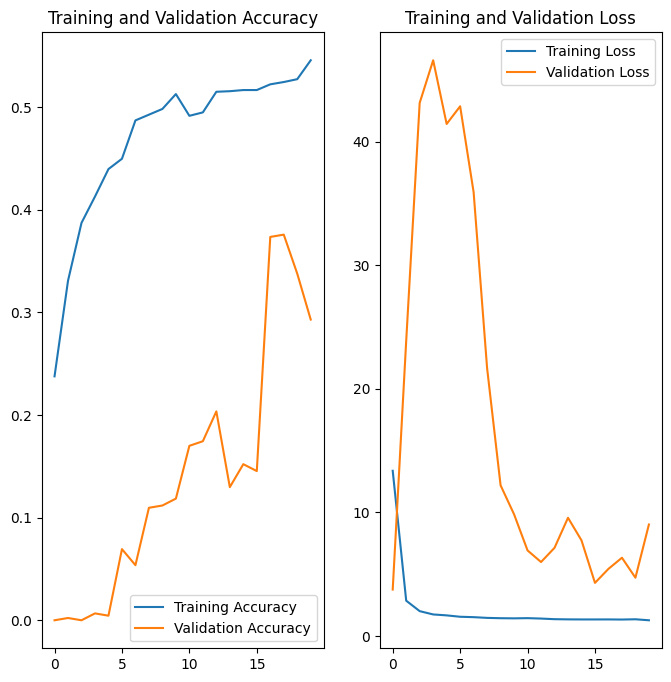

In [244]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- This model is underfitting with training accuracy as 0.53 and validation accuracy as 0.29
- 
While the training loss is clearly decreasing, but the validation loss is fluctuating a lot.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class distribution:
pigmented benign keratosis: 370
basal cell carcinoma: 309
vascular lesion: 115
nevus: 277
melanoma: 352
seborrheic keratosis: 58
dermatofibroma: 77
squamous cell carcinoma: 142
actinic keratosis: 92


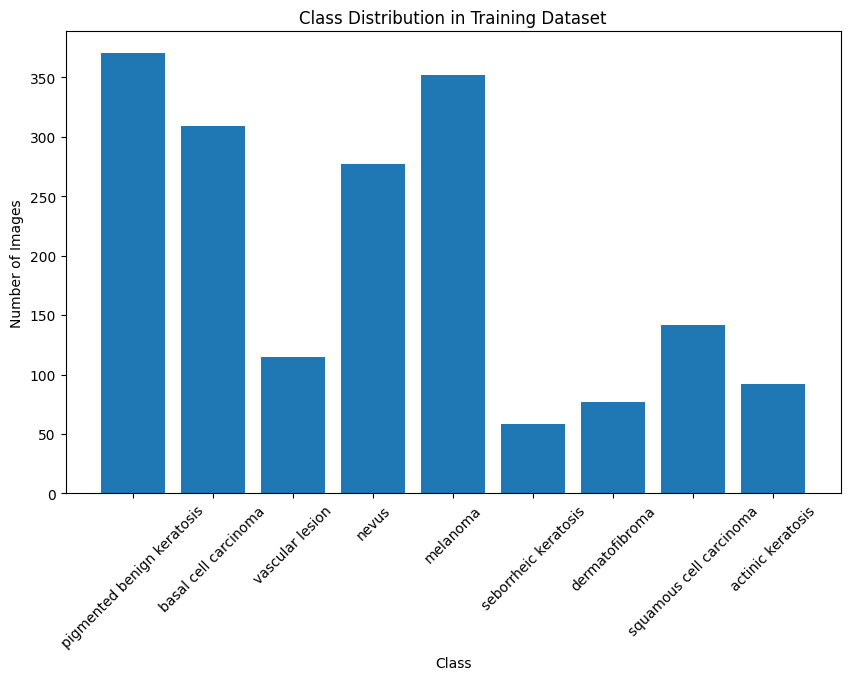

In [246]:
class_counts = {}

# Count occurrences of each class in the dataset
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] = class_counts.get(class_names[label], 0) + 1

# Print the class distribution
print("Class distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Visualize the class distribution with a bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- seborrheic keratosis class has the least number of sample.
#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis, melanoma and basal cell carcinoma dominate the data.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [247]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [248]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [249]:
path_to_training_dataset="Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x25858EB7990>: 100%|█| 500/500 [00:01<00:


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x25858F5B2D0>: 100%|█| 500/500 [00:01<00:


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25858EF0AD0>: 100%|█| 500/500 [00:01<00:00, 350.57 Samples


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2584324BDD0>: 100%|█| 500/500 [00:05<00:00, 98.23 Samples


Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2584B4E9F90>: 100%|█| 500/500 [00:05<00:00, 92.24 Samples/


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25858F4D8D0>: 100%|█| 500/500 [00:01<00:00, 336.03 Samples


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x258431DE350>: 100%|█| 500/500 [00:02<00:00, 205.95 Sample


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25849FB7750>: 100%|█| 500/500 [00:01<00:00, 339.60 Samples


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2584B617750>: 100%|█| 500/500 [00:01<00:00, 351.73 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [250]:
import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [251]:

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_18c9a6e3-a68a-4372-9260-7a4a9a868a4d.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a21c7d0c-0b4e-4696-a23b-52cc34e50910.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a9f28660-4a89-463b-9457-77f46a161beb.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f12cadeb-0fa8-4af1-a589-fd488974304e.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_378af48b-a724-4c10-9829-710dfe49a1be.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_6ec5e315-5c01-4161-b287-7fe4568e817e.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_817f1d65-e04a-4b39-b017-0df873e01f25.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_cd899e6d-9035-4775-9c95-3f9a8e7539c7.jpg',
 'Train\\actinic

In [252]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [253]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [254]:
original_df = pd.DataFrame(columns=['Path', 'Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)
new_df.head()

,Path,Label
0,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
1,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
2,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
3,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
4,Train\actinic keratosis\output\actinic keratos...,actinic keratosis


In [255]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [256]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [257]:
data_dir_train="Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [258]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [268]:
model = Sequential()
model.add(layers.Rescaling(1.0 / 255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),

model.add(Conv2D(64, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),

model.add(Conv2D(128, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),
model.add(Dropout(0.5)),

model.add(Conv2D(256, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D((2, 2))),

model.add(Flatten()),
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01))),
model.add(Dropout(0.25)),
model.add(Dense(len(train_ds.class_names), activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [269]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  
    decay_steps=1000,            
    decay_rate=0.96,             
    staircase=True               
)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer= Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    "best_model.keras",   
    monitor='val_accuracy',  
    save_best_only=True,  
    verbose=1
)


# Callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=3,          
    min_lr=1e-6,         
    verbose=1
)

#### **Todo:**  Train your model

In [270]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint_callback, reduce_lr]
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2987 - loss: 32.3584
Epoch 1: val_accuracy improved from -inf to 0.13363, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 432ms/step - accuracy: 0.2989 - loss: 32.2917 - val_accuracy: 0.1336 - val_loss: 18.1688 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.4317 - loss: 6.6925
Epoch 2: val_accuracy improved from 0.13363 to 0.18114, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 422ms/step - accuracy: 0.4316 - loss: 6.6851 - val_accuracy: 0.1811 - val_loss: 6.6664 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4301 - loss: 4.3510
Epoch 3: val_accuracy improved from 0.18114 to 0.34818, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 428ms/step - accuracy: 0.4300 - loss: 4.3551 - val_accuracy: 0.3482 - val_loss: 5.2053 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━

#### **Todo:**  Visualize the model results

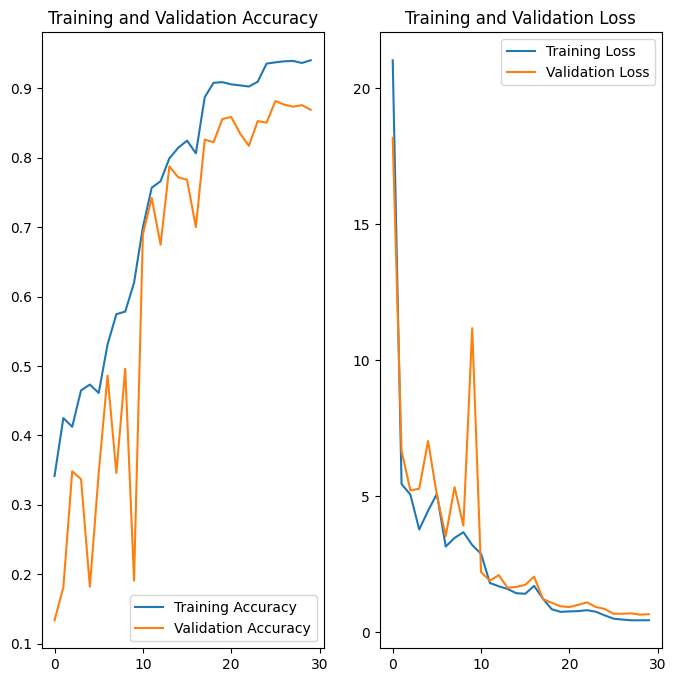

In [271]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- After adding the additional images using Augmentor library, now we can get rid of underfitting/overfitting. The class rebalance helped in achieving this outcome.
- The training accuracy is 0.93 and validation accuracy is 0.86, with the consistent decrease in loss for both training and validation.